In [1]:
# API KEY Loading
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH21-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-LangGraph


# LangGraph Streaming

In [3]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews

### 상태 정의
* `messages: Annotated[List[BaseMessage], add_messages]` : 새로운 메시지가 들어오면 기존 리스트를 덮어쓰지(기본 방식) 말고, Reducer로 add_messages를 사용하여 **"추가(append)"** 하라고 지정
* `dummy_data: str` : 기본 동작으로 **덮어쓰기** 를 수행, 노드가 dummy_data에 대한 새 값을 반환하면 이전 값은 사라지고 새 값으로 대체됨.

In [4]:
from langchain_core.messages import BaseMessage

########## 1. State ##########
class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    dummy_data: str


########## 2. TOOLS ##########
# 도구 초기화
news_tool = GoogleNews()

# 키워드 뉴스 검색 도구 생성
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""

    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)

tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# LLM + 도구 
llm_with_tools = llm.bind_tools(tools)


########## 3. NODE ##########
# 챗봇 함수 정의
def chatbot(state: State):
    
    response = llm_with_tools.invoke(state["messages"])

    # 변경이 필요한 필드만 포함하는 딕셔너리를 반환
    return {
        "messages": [response],
        "dummy_data": "[chatbot] 호출"
    }

### 그래프 빌드
* `tools_condition` : 챗봇의 마지막 메시지를 확인해서, 만약 **도구 호출(tool_calls)** 이 포함되어 있으면 **'tools'** 라는 글자를 반환하고, 그렇지 않으면 **'end'** 라는 글자를 반환

```python
def tools_condition(state: {"messages": List[BaseMessage]}) -> str:
    """
    미리 작성된 편의 함수.
    마지막 메시지에 tool_calls가 있는지 확인하여 다음 노드의 이름을 반환한다.
    """
    # 1. 상태에서 마지막 메시지를 꺼낸다.
    last_message = state["messages"][-1]

    # 2. 메시지에 tool_calls가 있는지 확인한다. (핵심 로직)
    if last_message.tool_calls:
        # 3a. 있으면 'tools'를 반환한다.
        return "tools"
    
    # 3b. 없으면 '__end__'를 반환한다.
    return END
```

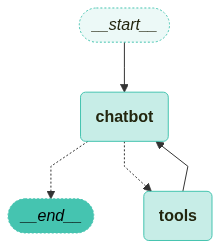

In [5]:

# Graph
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools))

# 그래프 흐름 연결
# 1) 시작점 지정: 'chatbot' 노드에서 시작
graph_builder.set_entry_point("chatbot")

# 2) 'chatbot' 노드 이후의 분기 처리 : 챗봇이 도구를 호출해야 한다고 판단하면 'tools' 노드로, 그렇지 않으면 대화를 종료(END)
graph_builder.add_conditional_edges("chatbot", tools_condition)

# 3) 'tools' 노드 이후의 흐름 : 도구 사용이 끝나면, 그 결과를 가지고 다시 'chatbot' 노드로 돌아감.
graph_builder.add_edge("tools", "chatbot")

# 4) 컴파일
graph = graph_builder.compile()


########## VISUALIZE ##########
visualize_graph(graph)

### 초기 상태 설정
상태 정의 클래스 `State`는 TypedDict 형식으로 TypedDict는 코드를 실행하기 전 정적 타입 검사를 위한 도구로 런타임에 특별한 기능을 하는 클래스가 아님.
- `initial_state = {"messages": [...]}` : `messages` 키를 가진 이 딕셔너리 데이터로 시작하라는 의미를 아주 명확하고 직관적으로 제공
- 만약 `initial_state = State(messages=[...])` 형식으로 사용하면 초기 상태를 State라는 클래스의 인스턴스를 생성하는 것처럼 보이지만, 실제로는 그냥 딕셔너리를 만드는 과정임. 따라서 불필요한 클래스 호출이 추가되어 코드가 더 길어지고, State가 특별한 객체인 것처럼 오해를 줄 수 있음.
- `class State(TypedDict)`: 그래프 전체에서 사용될 상태의 구조(schema)를 정의하는 설계도로 "상태는 반드시 'messages'와 'dummy_data'라는 키를 가져야 한다"는 규칙을 정하는 것.
- `initial_state`: 그래프를 시작시키는 첫 번째 입력 데이터로 위에서 정의한 설계도를 따르기만 하면 됨.

In [25]:
from langchain_core.messages import HumanMessage

# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 그래프의 첫 시작 상태를 딕셔너리 형태로 정의
initial_state = {
    "messages": [HumanMessage(content=question)]
}

### Graph 실행 옵션 설정
- `recursion_limit=10` : 재귀 호출 제한 - 에이전트가 무한 루프에 빠지지 않도록 최대 실행 횟수를 10회로 제한
- `configurable={"thread_id": "user_session_001"}` : 설정 가능 필드 - 대화 기록을 관리하기 위해 세션 ID 또는 스레드 ID를 지정
- `tags=["nobel_prize_agent"]` : 태그 - LangSmith 같은 추적 도구에서 실행 과정을 필터링하기 위한 태그

In [26]:
from langchain_core.runnables import RunnableConfig

# 그래프 실행 시 적용될 상세 설정
config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "user_session_001"},
    tags=["nobel_prize_agent"],
)

### StateGraph의 `stream` 메서드
`graph.stream()`은 그래프를 한 단계씩 실행하고, 각 단계(노드)의 실행이 끝날 때마다 그 결과를 반환하며, 단계별 반환 변수에는 해당 시점의 결과물이 포함(`Iterator[Union[dict[str, Any], Any]]`)됨.

매개변수
- `input` (Union[dict[str, Any], Any]): 그래프에 대한 입력
- `config` (Optional[RunnableConfig]): 실행 구성
- `stream_mode` (Optional[Union[StreamMode, list[StreamMode]]]): 출력 스트리밍 모드
- `output_keys` (Optional[Union[str, Sequence[str]]]): 스트리밍할 키
- `interrupt_before` (Optional[Union[All, Sequence[str]]]): 실행 전에 중단할 노드
- `interrupt_after` (Optional[Union[All, Sequence[str]]]): 실행 후에 중단할 노드
- `debug` (Optional[bool]): 디버그 정보 출력 여부
- `subgraphs` (bool): 하위 그래프 스트리밍 여부

※ 출력 스트리밍 모드
- `values`: 각 단계의 현재 상태 값 출력
- `updates`: 각 단계의 상태 업데이트만 출력
- `debug`: 각 단계의 디버그 이벤트 출력

In [46]:
for step in graph.stream(initial_state, config=config):
    for node_name, node_output in step.items():
        print(f"\n **[{node_name}]**")
        # 노드의 출력값 안에 'messages' 키가 있는지 확인 - ToolNode에는 messages가 없을 수 있음
        if "messages" in node_output:
            # 가장 마지막에 추가된 최신 메시지만 예쁘게 출력
            print(f"메시지 개수: {len(node_output['messages'])}")
            last_message = node_output["messages"][-1]
            last_message.pretty_print()


 **[chatbot]**
메시지 개수: 1
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_5CmyotSCroN7qeilyBFYQNvN)
 Call ID: call_5CmyotSCroN7qeilyBFYQNvN
  Args:
    query: 2024 Nobel Prize in Literature

 **[tools]**
메시지 개수: 1
================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMijAFBVV95cUxQbm5WUEJkclg3SDdkQXdlT3NqbUo4Qk9Wck83YWRYU09FanRwM2hyQjBWZm5PRlktX05vN3BmbEc4eUVSazhSX3o3bjNWSENOaTVUMWlTdnpXQnNMRS1ndXRmc1dCNEtoc2xCbXZUVllQVWFVZTdHWWE3TWJhV2Y2WXJFTUliUHZhWlFNbA?oc=5", "content": "Han Kang – Banquet speech - NobelPrize.org"}, {"url": "https://news.google.com/rss/articles/CBMigwFBVV95cUxNRGxDMlZxRnFuS1ZxTW1JZmhyNFZlRUVzb2UzbWJYbkhUSTB1OTF0dU5BM2VEU25SNnlFejd4LXoxUjEtVmZrTm1sWTZyb2U4UXBUeXExOHVhVXduSXJ2LWt3ZGJUS0VLQ1N2U2dSNkw3elN4UjRnLXFzNDBkWWkyZjFFSQ?oc=5", "content": "한강 \"문학, 생명을 파괴하는 모든 행위에 반대하는 일\" - Korea.net"}, {"url": "ht

### `output_keys`

- `output_keys` : 스트리밍할 키를 지정하는 데 사용
- list 형식으로 지정할 수 있으며, channels 에 정의된 키 중 하나
- 매 단계마다 출력되는 State key 가 많은 경우, 일부만 스트리밍하고 싶은 경우에 유용

In [54]:
# channels 에 정의된 키 목록 출력
print(list(graph.channels.keys()))

['messages', 'dummy_data', '__start__', '__pregel_tasks', 'branch:to:chatbot', 'branch:to:tools']


* channels 에 정의된 키 목록 중 'output_keys'를 설정하여 스트림의 출력 필드를 한정할 수 있음.

```python
# 'output_keys'를 설정하여 스트림의 출력 필드를 "messages"로 한정
stream = graph.stream(
    initial_state,
    config=run_config,
    output_keys=["messages"]
)
```

### `stream_mode="values"`: 노드에 대한 정보 없이 각 단계의 모든 값
* `node_name`: 상태의 key값
* `node_output`: 상태의 value값 (배열 포함)

In [55]:
for step in graph.stream(initial_state, config=config, stream_mode="values"):
    for node_name, node_output in step.items():
        if node_name == "messages":
            print(f"{node_name} 개수: {len(node_output)}")
        else:
            print(f"{node_name} : {node_output}")
    print("===" * 30)


messages 개수: 1
messages 개수: 2
dummy_data : [chatbot] 호출
messages 개수: 3
dummy_data : [chatbot] 호출
messages 개수: 4
dummy_data : [chatbot] 호출


### `stream_mode = "updates"`: 각 단계에 대한 업데이트된 State 만 내보냄
* `node_name`: 노드(Node) 의 이름
* `node_output`: 해당 노드(Node) 단계에서의 출력 값(dictionary). 즉, 여러 개의 key-value 쌍을 가진 dictionary

In [57]:
# stream_mode를 지정하지 않은 것과 동일
for step in graph.stream(initial_state, config=config, stream_mode="updates"):
    for node_name, node_output in step.items():
        print(f"\n **[{node_name}]**")
        if "messages" in node_output:
            print(node_output["messages"])
            print(f"메시지 개수: {len(node_output["messages"])}")
            last_message = node_output["messages"][-1]
            last_message.pretty_print()


 **[chatbot]**
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IfwsYjuRpNjPR0UElc4SCMKp', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 57, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BrfzNKumrRnD4SbQyrGO1J9q7Qdo9', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--46ddecbf-5507-409e-a1a6-7681db67fc18-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 Nobel Prize in Literature'}, 'id': 'call_IfwsYjuRpNjPR0UElc4SCMKp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 5

### `interrupt_before`, `interrupt_after`

- `interrupt_before`: 지정된 노드 이전에 스트리밍 중단
- `interrupt_after`: 지정된 노드 이후에 스트리밍 중단

In [58]:
# tools 노드 이전에 스트리밍 중단
for step in graph.stream(initial_state, config=config, interrupt_before=["tools"]):
    for node_name, node_output in step.items():
        print(f"\n **[{node_name}]**")
        if "messages" in node_output:
            print(node_output["messages"])
            print(f"메시지 개수: {len(node_output["messages"])}")
            last_message = node_output["messages"][-1]
            last_message.pretty_print()


 **[chatbot]**
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GrhPw0uKRMStp20pQdUzPiJd', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 57, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BrgB6AfwNzLtFF2rdgu7QA14YHVBR', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3d7c0cdb-afc8-4fb5-afec-fc9354b53edf-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 Nobel Prize in Literature'}, 'id': 'call_GrhPw0uKRMStp20pQdUzPiJd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 5

In [59]:
# tools 노드 이전에 스트리밍 중단
for step in graph.stream(initial_state, config=config, interrupt_after=["tools"]):
    for node_name, node_output in step.items():
        print(f"\n **[{node_name}]**")
        if "messages" in node_output:
            print(node_output["messages"])
            print(f"메시지 개수: {len(node_output["messages"])}")
            last_message = node_output["messages"][-1]
            last_message.pretty_print()


 **[chatbot]**
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_s61A5Z0aRR59FS7YgbecSeVx', 'function': {'arguments': '{"query":"2024 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 57, 'total_tokens': 77, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BrgCLT96fJ9w0l1TIAUxnKQjUacMw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--73212d0f-dd6e-4e24-a44c-33c82d7e6a7a-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 노벨 문학상'}, 'id': 'call_s61A5Z0aRR59FS7YgbecSeVx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 20, 'total_tokens'

-----
** End of Documents **